# Texas Scraper from Excel Sheet

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
import zipfile
import pandas as pd
from io import StringIO
import requests
import csv
import time
import random

# Creating Dataframe from xlsx link

In [3]:
#pip import xlrx (Python Library extract Excel spreadsheets)

TexasXlslUrl = "https://dshs.texas.gov/coronavirus/TexasCOVID19Demographics.xlsx.asp"

#takes data from the "cases by RaceEthnicity" tab in the spreadsheet
casesByRaceAndEthnicity = pd.read_excel(TexasXlslUrl, "Cases by RaceEthnicity")

#takes data from the "Fatalities by Race=Ethnicity" tab in the spreadsheet
deathsByRaceAndEthnicity = pd.read_excel(TexasXlslUrl, "Fatalities by Race-Ethnicity")


# cleaning up data

In [4]:
#renames column names to be more descriptive
casesByRaceAndEthnicity.rename(columns = {'Number':'Cases'}, inplace = True)
casesByRaceAndEthnicity.rename(columns = {'%':'Percentage of Total Cases'}, inplace = True)

deathsByRaceAndEthnicity.rename(columns = {'Number':'Deaths'}, inplace = True)
deathsByRaceAndEthnicity.rename(columns = {'%':'Percentage of Total Deaths'}, inplace = True)

# Data Frame for Cases

In [5]:
casesByRaceAndEthnicity

,Race/Ethnicity,Cases,Percentage of Total Cases
0,Asian,847,0.014622
1,Black,9533,0.164566
2,Hispanic,22986,0.396803
3,Other,273,0.004713
4,White,17595,0.303739
5,Unknown,6694,0.115557
6,Total,57928,1.000000


# Data Frame for Fatalities

In [6]:
deathsByRaceAndEthnicity

,Race/Ethnicity,Deaths,Percentage of Total Deaths
0,Asian,326,0.018178
1,Black,1949,0.108676
2,Hispanic,9925,0.553418
3,Other,96,0.005353
4,White,5626,0.313706
5,Unknown,12,0.000669
6,Total,17934,1.000000


## Let's plot some data and get some data about the data (very meta 😎)

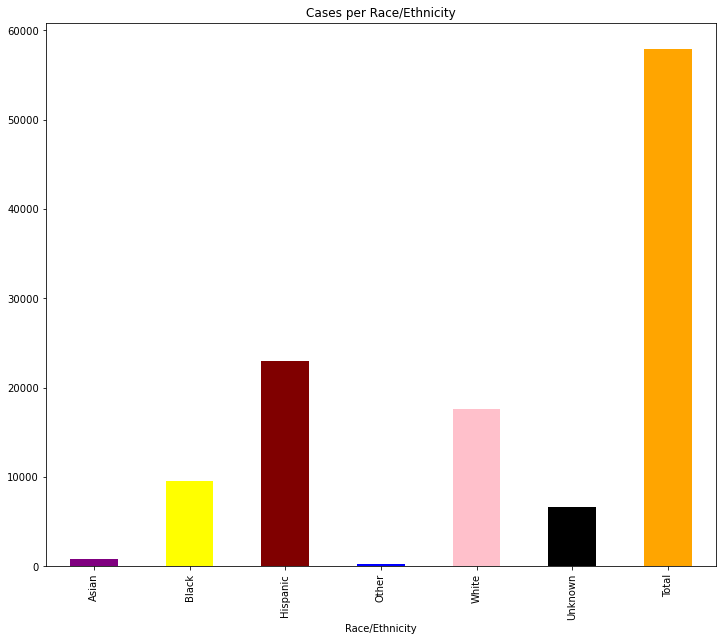

In [15]:

casesByRaceAndEthnicity.set_index('Race/Ethnicity')['Cases'].plot.bar(figsize=(12, 10), title='Cases per Race/Ethnicity'
                                                                        ,linewidth=2.5, color=['purple', 'yellow','maroon','blue','pink', 'black', 'orange'])

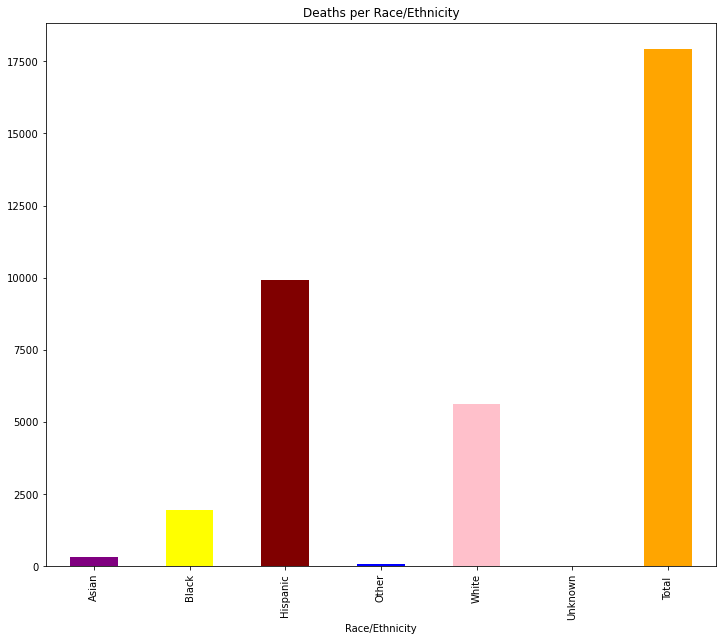

In [16]:

deathsByRaceAndEthnicity.set_index('Race/Ethnicity')['Deaths'].plot.bar(figsize=(12, 10), title='Deaths per Race/Ethnicity'
                                                                        ,linewidth=2.5, color=['purple', 'yellow','maroon','blue','pink', 'black', 'orange'])